In [2]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import bped2.pedigree as pd 

In [3]:
import matplotlib.pyplot as plt
mycmap=plt.get_cmap('Pastel1')

def nodevalue(n):
    cols={"X":0.5,
              "S":0.9,
              "m":0.7,
              "f":0.75}
    return cols[n[0]]

# Pedigree's loading

In [12]:
ped = pd.Pedigree()
ped.load('../data/ped/famRh.ped')


NameError: name 'pd' is not defined

# Bayesien Networks Generation's

In [2]:
def load_evidence(file,famID):
    tab = dict()
    with open(file,'r') as f:
        for (line,i) in enumerate(f.readlines()):
            ev = i.split()
            idfam = ev[0].split(':')[0]
            if ev[0] == famID:
                # del ev[0],ev[1]
                ev = [float(i) for i in ev[2:]]
                tab[f'X{line+1}'] = ev
    return tab

In [3]:
def load_evidence_out(file,famID):
    tab = dict()
    with open(file,'r') as f:
        for (line,i) in enumerate(f.readlines()):
            ev = i.split()
            f_id = ev[0].split(':')[0]
            if f_id == f'X_{famID}':
                key = ev[0].split(':')[1]
                ev = [float(i) for i in ev[1:]]
                tab[f'X{key}'] = ev
    return tab

load_evidence_out('../data/famRh.out','0')

{'X1': [0.0, 0.495, 0.495, 0.01],
 'X2': [1.0, 0.0, 0.0, 0.0],
 'X3': [0.0, 1.0, 0.0, 0.0],
 'X4': [0.0, 0.5, 0.5, 0.0],
 'X5': [0.0, 0.333333, 0.333333, 0.333333],
 'X6': [0.0, 0.333333, 0.333333, 0.333333],
 'X7': [1.0, 0.0, 0.0, 0.0],
 'X8': [0.0, 0.333333, 0.333333, 0.333333],
 'X9': [1.0, 0.0, 0.0, 0.0]}

In [4]:
def createInd(bn,p,f):
    bn.add(gum.LabelizedVariable(f"matX{p.pID}",f"mother of {p.pID}",["0","1"]))
    bn.add(gum.LabelizedVariable(f"fatX{p.pID}",f"father of {p.pID}",["0","1"]))
    bn.add(gum.LabelizedVariable(f"X{p.pID}",f"{p.pID}",["00","01","10","11"]))
    bn.addArc(f"fatX{p.pID}",f"X{p.pID}")
    bn.addArc(f"matX{p.pID}",f"X{p.pID}")
    bn.cpt(f"X{p.pID}").fillWith([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1])


In [5]:
def joindreParent(bn,p,parent):
    #parent = fat ou mat
    if parent == 'fat':
        parentID = p.fatID
    else:
        parentID = p.matID
    
    #Creating Selector 
    bn.add(gum.LabelizedVariable(f"S{parent}{p.pID}",f"Selector of {parent}ID",["fat","mat"]))
    bn.cpt(f"S{parent}{p.pID}").fillWith([0.5,0.5])
    
    bn.addArc(f"fatX{parentID}",f"{parent}X{p.pID}")
    bn.addArc(f"matX{parentID}",f"{parent}X{p.pID}")         
    bn.addArc(f"S{parent}{p.pID}",f"{parent}X{p.pID}") # Selector to fat/mat

    bn.cpt(f"{parent}X{p.pID}").fillWith([1,0,1,0,0,1,0,1,1,0,0,1,1,0,0,1])

In [6]:
def joindreParent_compact(bn,p,parent):
    #parent = fat ou mat
    if parent == 'fat':
        parentID = p.fatID
    else:
        parentID = p.matID
    
    bn.addArc(f"fatX{parentID}",f"{parent}X{p.pID}")
    bn.addArc(f"matX{parentID}",f"{parent}X{p.pID}")         

    bn.cpt(f"{parent}X{p.pID}").fillWith([1,0,0.5,0.5,0.5,0.5,0,1])

In [7]:
def bn(ped,f):
    bn = gum.BayesNet()
    for p in ped.get_pedigree().values():
        createInd(bn,p,f)
        
    for p in ped.get_pedigree().values():   
        if p.fatID == '0': # Cas parents inconnu
            bn.cpt(f"fatX{p.pID}").fillWith([1-f,f])
        else: 
            joindreParent(bn,p,'fat')
        
        if p.matID == '0': # Cas parents inconnu
            bn.cpt(f"matX{p.pID}").fillWith([1-f,f])
        else:
            joindreParent(bn,p,'mat')
        
    gnb.showBN(bn,size=100)
    return bn

In [11]:
def bn_compact(ped,f):
    bn = gum.BayesNet()
    for p in ped.get_pedigree().values():
        createInd(bn,p,f)
    for p in ped.get_pedigree().values():   
        if p.fatID == '0': # Cas parents inconnu
            bn.cpt(f"fatX{p.pID}").fillWith([1-f,f])
        else: 
            joindreParent_compact(bn,p,'fat')
        
        if p.matID == '0': # Cas parents inconnu
            bn.cpt(f"matX{p.pID}").fillWith([1-f,f])
        else:
            joindreParent_compact(bn,p,'mat')
        
    gnb.showBN(bn,size=100)
    return bn

In [13]:
bn = bn(ped,0.05)
bn.cpt('fatX1')

NameError: name 'ped' is not defined

In [14]:
bn2 = bn_compact(ped,0.05)
bn2.cpt('fatX5')

NameError: name 'bn_compact' is not defined

## Inference without evidence

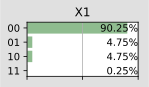

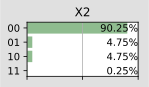

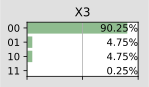

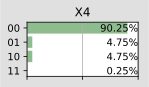

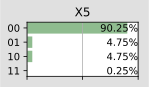

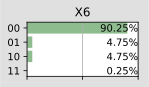

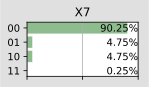

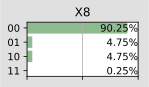

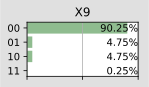

In [14]:
ie=gum.LazyPropagation(bn)
ie.makeInference()
for i in ped.get_pedigree().keys():
    gnb.showProba(ie.posterior(f"X{i}"))

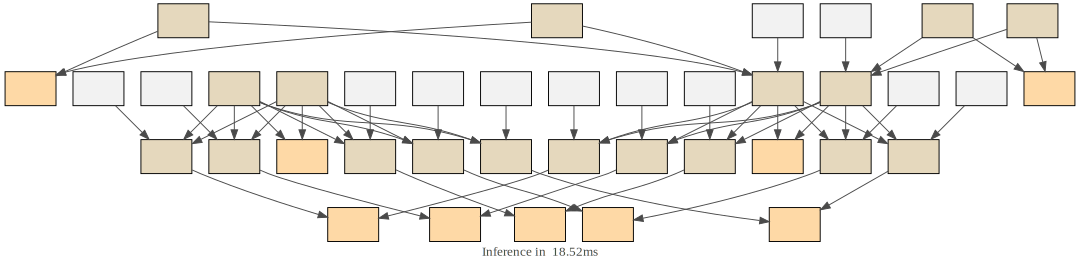

In [15]:
gnb.showInference(bn,size=15,nodeColor={n:nodevalue(n) for n in bn.names()},cmap=mycmap)

## Inference with evidence

In [16]:
ped = pd.Pedigree()
ped.load('../data/ped/famRh.ped')
bn_with_ev = bn(ped,0.01)
ie=gum.LazyPropagation(bn_with_ev)

TypeError: 'BayesNet' object is not callable

In [25]:
evidence = load_evidence('../data/famRh.ev','0')
evidence

{'X1': [0.0, 1.0, 1.0, 1.0],
 'X2': [1.0, 0.0, 0.0, 0.0],
 'X3': [0.0, 1.0, 1.0, 1.0],
 'X4': [0.0, 1.0, 1.0, 1.0],
 'X5': [0.0, 1.0, 1.0, 1.0],
 'X6': [0.0, 1.0, 1.0, 1.0],
 'X7': [1.0, 0.0, 0.0, 0.0],
 'X8': [0.0, 1.0, 1.0, 1.0],
 'X9': [1.0, 0.0, 0.0, 0.0]}

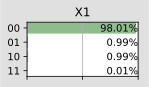

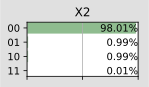

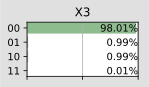

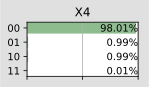

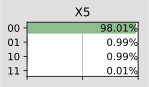

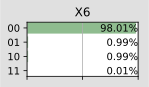

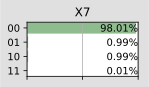

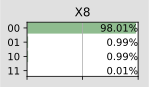

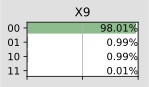

In [16]:
for i in ped.get_pedigree().keys():
    gnb.showProba(ie.posterior(f"X{i}"))

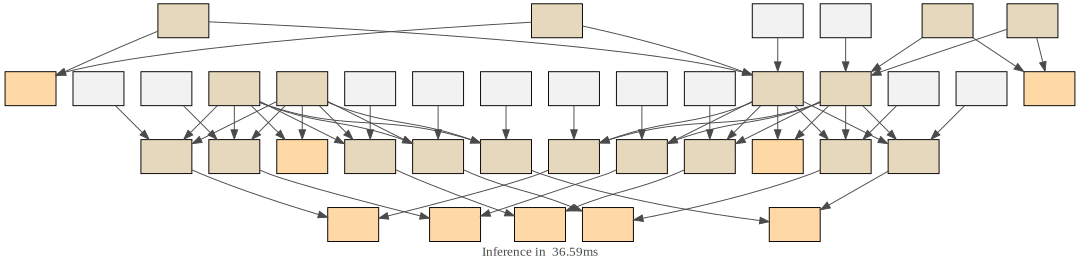

In [17]:
gnb.showInference(bn_with_ev,size=15,nodeColor={n:nodevalue(n) for n in bn_with_ev.names()},cmap=mycmap)

## Checking evidence 

In [18]:
ped_N8 = pd.Pedigree()
ped_N8.load('../data/ped/senegal2013.ped')
ped_N8 = ped_N8.gen_family_pedigree('N8')

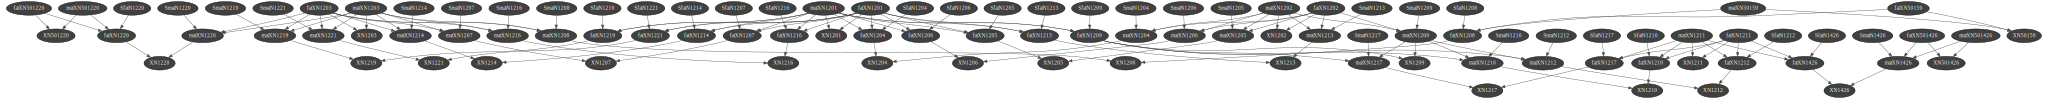

<XN501220:00> :: 0.9801 /<XN501220:01> :: 0.0099 /<XN501220:10> :: 0.0099 /<XN501220:11> :: 0.0001
<XN1201:00> :: 0.9801 /<XN1201:01> :: 0.0099 /<XN1201:10> :: 0.0099 /<XN1201:11> :: 0.0001
<XN1202:00> :: 0.9801 /<XN1202:01> :: 0.0099 /<XN1202:10> :: 0.0099 /<XN1202:11> :: 0.0001
<XN1203:00> :: 0.9801 /<XN1203:01> :: 0.0099 /<XN1203:10> :: 0.0099 /<XN1203:11> :: 0.0001
<XN1204:00> :: 0.9801 /<XN1204:01> :: 0.0099 /<XN1204:10> :: 0.0099 /<XN1204:11> :: 0.0001
<XN1205:00> :: 0.9801 /<XN1205:01> :: 0.0099 /<XN1205:10> :: 0.0099 /<XN1205:11> :: 0.0001
<XN1206:00> :: 0.9801 /<XN1206:01> :: 0.0099 /<XN1206:10> :: 0.0099 /<XN1206:11> :: 0.0001
<XN1207:00> :: 0.9801 /<XN1207:01> :: 0.0099 /<XN1207:10> :: 0.0099 /<XN1207:11> :: 0.0001
<XN1208:00> :: 0.9801 /<XN1208:01> :: 0.0099 /<XN1208:10> :: 0.0099 /<XN1208:11> :: 0.0001
<XN1209:00> :: 0.9801 /<XN1209:01> :: 0.0099 /<XN1209:10> :: 0.0099 /<XN1209:11> :: 0.0001
<XN1210:00> :: 0.9801 /<XN1210:01> :: 0.0099 /<XN1210:10> :: 0.0099 /<XN1210:11> :

In [19]:
bn_N8 = bn(ped_N8,0.01)
ie=gum.LazyPropagation(bn_N8)
ie.makeInference()
for i in ped_N8.get_pedigree().keys():
    #gnb.showProba(ie.posterior(f"X{i}"))
    print(ie.posterior(f"X{i}"))

In [20]:
ev_out_N8 = load_evidence_out('../data/senegal2013_noev.out','N8')
ev_out_N8

{'XN501220': [0.9801, 0.0099, 0.0001],
 'XN1201': [0.9801, 0.0099, 0.0001],
 'XN1202': [0.9801, 0.0099, 0.0001],
 'XN1203': [0.9801, 0.0099, 0.0001],
 'XN1204': [0.9801, 0.0099, 0.0001],
 'XN1205': [0.9801, 0.0099, 0.0001],
 'XN1206': [0.9801, 0.0099, 0.0001],
 'XN1207': [0.9801, 0.0099, 0.0001],
 'XN1208': [0.9801, 0.0099, 0.0001],
 'XN1209': [0.9801, 0.0099, 0.0001],
 'XN1210': [0.9801, 0.0099, 0.0001],
 'XN1211': [0.9801, 0.0099, 0.0001],
 'XN1212': [0.9801, 0.0099, 0.0001],
 'XN1213': [0.9801, 0.0099, 0.0001],
 'XN1214': [0.9801, 0.0099, 0.0001],
 'XN1216': [0.9801, 0.0099, 0.0001],
 'XN1217': [0.9801, 0.0099, 0.0001],
 'XN1219': [0.9801, 0.0099, 0.0001],
 'XN1220': [0.9801, 0.0099, 0.0001],
 'XN1221': [0.9801, 0.0099, 0.0001],
 'XN1426': [0.9801, 0.0099, 0.0001],
 'XN501426': [0.9801, 0.0099, 0.0001],
 'XN50159': [0.9801, 0.0099, 0.0001]}

In [21]:
ped_N9 = pd.Pedigree()
ped_N9.load('../data/ped/senegal2013.ped')
ped_N9 = ped_N9.gen_family_pedigree('N9')

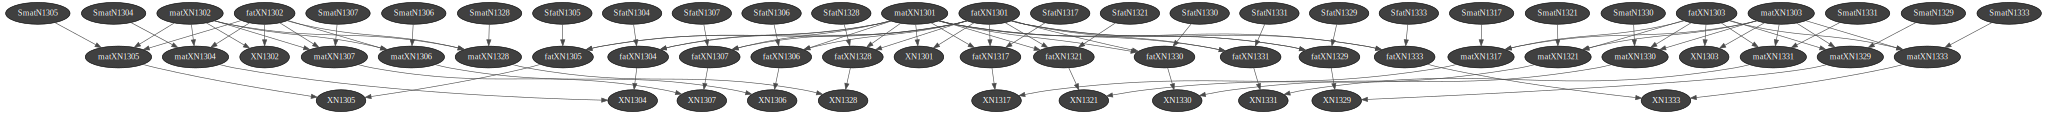

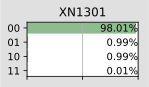

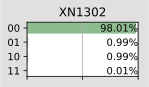

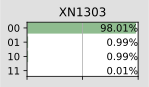

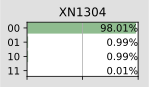

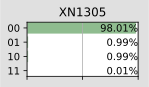

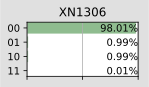

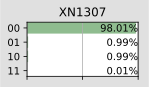

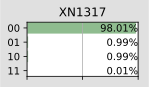

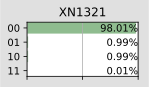

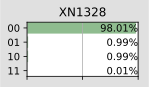

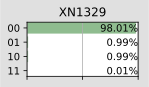

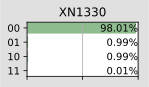

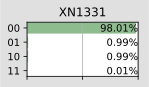

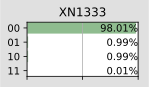

In [22]:
bn_N9 = bn(ped_N9,0.01)
ie=gum.LazyPropagation(bn_N9)
ie.makeInference()
for i in ped_N9.get_pedigree().keys():
    gnb.showProba(ie.posterior(f"X{i}"))

In [23]:
ev_out_N9 = load_evidence_out('../data/senegal2013_noev.out','N9')
ev_out_N9

{'XN1301': [0.9801, 0.0099, 0.0001],
 'XN1302': [0.9801, 0.0099, 0.0001],
 'XN1303': [0.9801, 0.0099, 0.0001],
 'XN1304': [0.9801, 0.0099, 0.0001],
 'XN1305': [0.9801, 0.0099, 0.0001],
 'XN1306': [0.9801, 0.0099, 0.0001],
 'XN1307': [0.9801, 0.0099, 0.0001],
 'XN1317': [0.9801, 0.0099, 0.0001],
 'XN1321': [0.9801, 0.0099, 0.0001],
 'XN1328': [0.9801, 0.0099, 0.0001],
 'XN1329': [0.9801, 0.0099, 0.0001],
 'XN1330': [0.9801, 0.0099, 0.0001],
 'XN1331': [0.9801, 0.0099, 0.0001],
 'XN1333': [0.9801, 0.0099, 0.0001]}

In [24]:
ped_D2 = pd.Pedigree()
ped_D2.load('../data/ped/senegal2013.ped')
ped_D2 = ped_D2.gen_family_pedigree('D2')

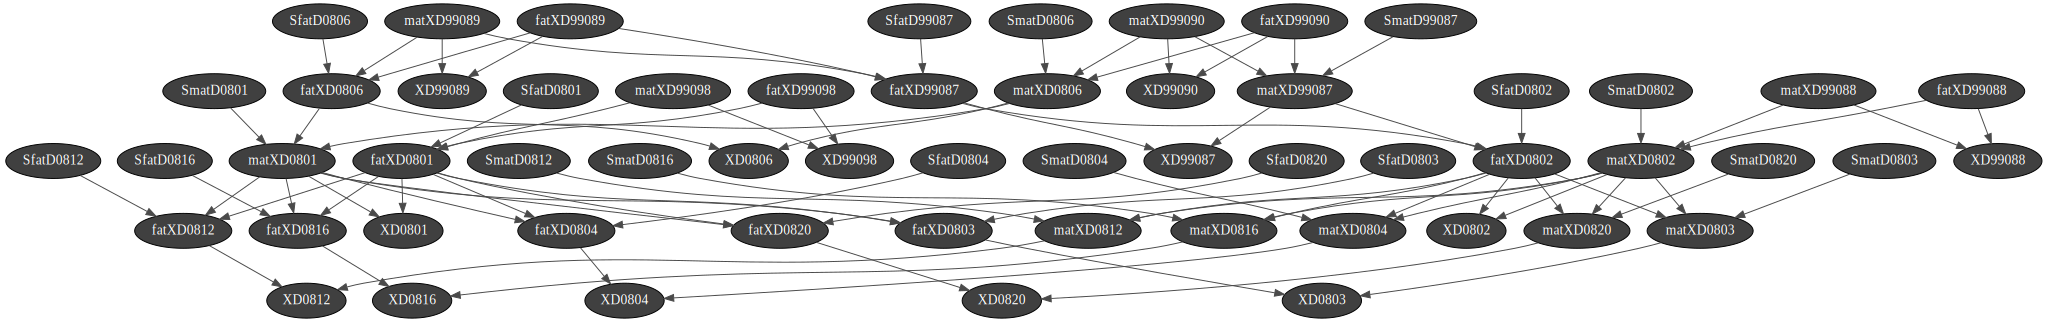

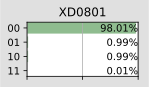

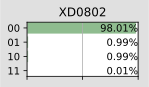

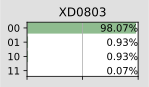

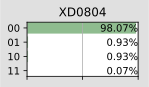

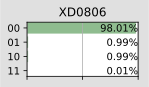

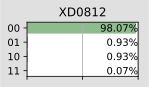

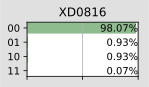

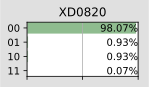

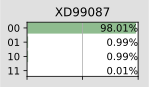

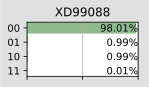

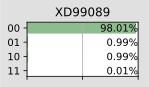

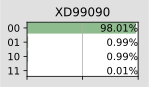

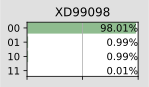

In [25]:
bn_D2 = bn(ped_D2,0.01)
ie=gum.LazyPropagation(bn_D2)
ie.makeInference()
for i in ped_D2.get_pedigree().keys():
    gnb.showProba(ie.posterior(f"X{i}"))

In [26]:
ev_out_D2 = load_evidence_out('../data/senegal2013_noev.out','D2')
ev_out_D2

{'XD0801': [0.9801, 0.0099, 0.0001],
 'XD0802': [0.9801, 0.0099, 0.0001],
 'XD0803': [0.980719, 0.00928125, 0.00071875],
 'XD0804': [0.980719, 0.00928125, 0.00071875],
 'XD0806': [0.9801, 0.0099, 0.0001],
 'XD0812': [0.980719, 0.00928125, 0.00071875],
 'XD0816': [0.980719, 0.00928125, 0.00071875],
 'XD0820': [0.980719, 0.00928125, 0.00071875],
 'XD99087': [0.9801, 0.0099, 0.0001],
 'XD99088': [0.9801, 0.0099, 0.0001],
 'XD99089': [0.9801, 0.0099, 0.0001],
 'XD99090': [0.9801, 0.0099, 0.0001],
 'XD99098': [0.9801, 0.0099, 0.0001]}

In [27]:
from time import *
import numpy as np
import matplotlib.pyplot as plt

In [28]:
f = 0.05
nb_ped = 50
nb_people = [10,20,50,100,200,300,500,1000]
nb_Gen_Max = [3,5,13,15,20,25,35,50]
nbChild = 4
cl = 4

mean_gen_ped = []
mean_gen_bn = []

errorValues_ped = []
errorValues_bn = []

max_ped = []
max_bn = []

min_ped = []
min_bn = []

In [31]:
for p,g in zip(nb_people,nb_Gen_Max):
    tab_ped = np.zeros(nb_ped)
    tab_bn = np.zeros(nb_ped)

    for nb in range(nb_ped):
        ped = pd.Pedigree()
        t1 = process_time()
        ped.gen_ped(nb, p, g, nbChild, cl)
        t2 = process_time()
        t3 = process_time()
        ped.ped_to_bn(f)
        t4 = process_time()
        ped.save(f'../cplex/pedigree_{p}_{g}_{nbChild}_{cl}_G{nb}')
        t2 = t2 - t1
        t4 = t4 - t3
        tab_ped[nb] = t2
        tab_bn[nb] = t4

    max_ped.append(tab_ped.max())
    max_bn.append(tab_bn.max())

    min_ped.append(tab_ped.min())
    min_bn.append(tab_bn.min())

    errorValues_ped.append(tab_ped.std())
    errorValues_bn.append(tab_bn.std())

    mean_gen_ped.append(tab_ped.mean())
    mean_gen_bn.append(tab_bn.mean())



NotFound: [pyAgrum] Object not found: hashtable's chained list contains no element with this key <fatX3>

In [ ]:
f1 = plt.figure(1)
plt.errorbar(nb_people, mean_gen_ped, yerr = errorValues_ped, ecolor='red')
plt.title('Temps d\'execution en fonction de la taille du pedigree')
plt.xlabel('Taille du pedigree')
plt.ylabel('Temps en sec')
plt.savefig('../data/figure/Temps d\'execution en fonction de la taille du pedigree avec ecart-type')
f1.show()

f2 = plt.figure(2)
plt.plot(nb_people, np.log(mean_gen_ped))
plt.title('Log du temps d\'execution en fonction de la taille du pedigree')
plt.xlabel('Taille du pedigree')
plt.ylabel('log du temps en sec')
plt.savefig('../data/figure/Log du temps d\'execution en fonction de la taille du pedigree')
f2.show()

f3 = plt.figure(3)
plt.plot(nb_people, mean_gen_ped, label='mean')
plt.plot(nb_people, max_ped, label='max')
plt.plot(nb_people, min_ped, label='min')
plt.legend(['mean','max','min'])
plt.title('Temps d\'execution en fonction de la taille du pedigree')
plt.xlabel('Taille du pedigree')
plt.ylabel('Temps en sec')
plt.savefig('../data/figure/Temps d\'execution moyen, min et max en fonction de la taille du pedigree')
f3.show()

f4 = plt.figure(4)
plt.errorbar(nb_people, mean_gen_bn, yerr = errorValues_bn, ecolor='red')
plt.title('Temps de génération du BN en fonction de la taille du pedigree')
plt.xlabel('Taille du pedigree')
plt.ylabel('Temps en sec')
plt.savefig('../data/figure/Temps de génération du BN en fonction de la taille du pedigree avec ecart-type')
f1.show()

f5 = plt.figure(5)
plt.plot(nb_people, mean_gen_bn, label='mean')
plt.plot(nb_people, max_bn, label='max')
plt.plot(nb_people, min_bn, label='min')
plt.legend(['mean','max','min'])
plt.title('Temps de génération du BN en fonction de la taille du pedigree')
plt.xlabel('Taille du pedigree')
plt.ylabel('Temps en sec')
plt.savefig('../data/figure/Temps de génération du BN moyen, min et max en fonction de la taille du pedigree')
f3.show()


plt.show()
